导入相关库

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Soft\Conda3\envs\python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据预处理

In [2]:
# 读取数据
df = pd.read_csv("data/processed_binary_compounds.csv")

# 要处理的列
stress_cols = ["sxy", "syz", "szx"]

# 替换值为0的项为该列的非零中位数
for col in stress_cols:
    non_zero_median = df.loc[df[col] != 0, col].median()
    df[col] = df[col].replace(0, non_zero_median)

print(df.shape)
df.columns.values

(10000, 22)


array(['delta_e', 'stability', 'natoms', 'ntypes',
       'element_1_atomic_radii', 'element_1_electronegativity',
       'element_1_mass', 'element_1_covalent_radii',
       'element_1_first_ionization_energy', 'element_2_atomic_radii',
       'element_2_electronegativity', 'element_2_mass',
       'element_2_covalent_radii', 'element_2_first_ionization_energy',
       'spacegroup_id', 'volume_pa', 'sxx', 'syy', 'szz', 'sxy', 'syz',
       'szx'], dtype=object)

特征工程

In [3]:
# 特征生成函数
def expand_features(df):
    eps = 1e-6

    # 1、组成特征
    for feat in ['atomic_radii', 'electronegativity', 'mass', 'covalent_radii', 'first_ionization_energy']:
        col1 = f'element_1_{feat}'
        col2 = f'element_2_{feat}'
        df[f'{feat}_avg'] = 0.5 * (df[col1] + df[col2])
        df[f'{feat}_diff'] = df[col1] - df[col2]
        df[f'{feat}_ratio'] = df[col1] / (df[col2] + eps)
        df[f'{feat}_sum'] = df[col1] + df[col2]
        df[f'{feat}_prod'] = df[col1] * df[col2]
        df[f'{feat}_diff_sq'] = (df[col1] - df[col2]) ** 2
        df[f'{feat}_sum_sq'] = (df[col1] + df[col2]) ** 2
        
    
    df['natoms_per_type'] = df['natoms'] / (df['ntypes'] + eps)

    for feat in ['electronegativity', 'atomic_radii', 'covalent_radii', 'first_ionization_energy']:
        df[f'mass_weighted_{feat}'] = (
            df[f'element_1_{feat}'] * df['element_1_mass'] + df[f'element_2_{feat}'] * df['element_2_mass']
        ) / (df['element_1_mass'] + df['element_2_mass'] + eps)

    # 2、结构特征（不含空间群embedding）
    df['volume_per_atom'] = df['volume_pa'] / (df['natoms'] + eps)
    df['volume_per_type'] = df['volume_pa'] / (df['ntypes'] + eps)
    df['volume_sq'] = df['volume_pa'] ** 2
    df['volume_sqrt'] = np.sqrt(df['volume_pa'] + eps)
    df['natoms_sqrt'] = np.sqrt(df['natoms'] + eps)
    df['ntypes_sqrt'] = np.sqrt(df['ntypes'] + eps)

    # 3、力学应力特征
    stress_cols = ['sxx', 'syy', 'szz', 'sxy', 'syz', 'szx']
    df['stress_mean'] = df[stress_cols].mean(axis=1)
    df['stress_std'] = df[stress_cols].std(axis=1)
    df['stress_max'] = df[stress_cols].max(axis=1)
    df['stress_min'] = df[stress_cols].min(axis=1)
    df['stress_range'] = df['stress_max'] - df['stress_min']
    df['stress_sum'] = df[stress_cols].sum(axis=1)
    df['stress_norm'] = np.sqrt((df[stress_cols] ** 2).sum(axis=1))
    df['shear_stress_mean'] = df[['sxy', 'syz', 'szx']].mean(axis=1)
    df['shear_stress_std'] = df[['sxy', 'syz', 'szx']].std(axis=1)
    df['stress_skew'] = df[stress_cols].apply(lambda x: x.skew(), axis=1)

    return df

# 删除不参与输入的字段
df_features = df.drop(columns=['delta_e'])

# 生成特征
df_full = expand_features(df_features)

df_full.shape

(10000, 77)

标准化

In [4]:
# 数值特征标准化
scaler = StandardScaler()
df_fullm_scaled = scaler.fit_transform(df_full)
df_delta_scaled = scaler.fit_transform(df[['delta_e']])
df_fullm_scaled.shape

(10000, 77)

构建空间群Embedding模块

In [5]:
# 确定spacegroup_id的类别数
num_spacegroups = df['spacegroup_id'].nunique()
print(f"空间群类别数: {num_spacegroups}")

空间群类别数: 145


In [6]:
# 转为Tensor
X_tensor = torch.tensor(df_fullm_scaled, dtype=torch.float32)

# 创建id → 索引映射（0开始的整数）
unique_sg = sorted(df['spacegroup_id'].unique())  # 实际总共145类
sgid2idx = {sg_id: idx for idx, sg_id in enumerate(unique_sg)}

# 将原spacegroup_id映射成连续索引
df['sg_idx'] = df['spacegroup_id'].map(sgid2idx)

# 定义embedding层
num_spacegroups = 145
embedding_dim = 16
sg_embedder = nn.Embedding(num_embeddings=num_spacegroups, embedding_dim=embedding_dim)

# 取出映射后的索引，转换为LongTensor
sg_idx_tensor = torch.tensor(df['sg_idx'].values, dtype=torch.long)

# 生成空间群embedding向量
sg_embedding_tensor = sg_embedder(sg_idx_tensor)

# 拼接数值特征 + 空间群embedding
X = torch.cat([X_tensor, sg_embedding_tensor], dim=1)

# 构建回归目标（形成能）
y = torch.tensor(df_delta_scaled, dtype=torch.float32).view(-1, 1)

print(X.shape)
print(y.shape)


torch.Size([10000, 93])
torch.Size([10000, 1])


自定义Dataset

In [7]:
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

划分训练集和测试集

In [8]:
# 创建完整数据集
full_dataset = EnergyDataset(X, y)

# 划分比例
test_size = int(0.2 * len(full_dataset))       # 2000
trainval_size = len(full_dataset) - test_size  # 8000

# 划分训练+验证 和 测试
trainval_dataset, test_dataset = random_split(full_dataset, [trainval_size, test_size])

# 再从 trainval 中划分训练集和验证集
val_size = int(0.2 * trainval_size)            # 1600
train_size = trainval_size - val_size          # 6400
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [9]:
# 准备数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

MLP + MC Dropout模型设计

In [10]:
class MLPWithMCDropout(nn.Module):
    def __init__(self, input_dim, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=True)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=True)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout_rate, training=True)
        return self.output(x)

定义MC Dropout推理函数（不确定性估计）

In [11]:
def get_mc_predictions(model, test_loader, T, device):
    model = model.to(device)
    model.train()  # 激活 Dropout 层
    all_preds = []

    with torch.no_grad():  # 不需要计算梯度
        for _ in range(T):
            preds = []
            for x_batch, _ in test_loader:
                x_batch = x_batch.to(device)
                pred = model(x_batch)
                preds.append(pred.cpu())
            all_preds.append(torch.cat(preds, dim=0))

    preds_stack = torch.stack(all_preds, dim=0)
    mean_pred = preds_stack.mean(dim=0).squeeze()
    std_pred = preds_stack.std(dim=0).squeeze()
    y_true = torch.cat([y for _, y in test_loader], dim=0).squeeze()

    return y_true.numpy(), mean_pred.numpy(), std_pred.numpy()

定义训练过程（可调epoch）

In [12]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward(retain_graph=True)
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item() * x_batch.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return model

模型训练

In [13]:
device = torch.device('cpu')

model = MLPWithMCDropout(input_dim=X.shape[1], dropout_rate=0.1)
model = train_model(model, train_loader, val_loader, epochs=120, lr=1e-4, device=device)

# 推理 + 不确定性估计
y_true, mean_pred, std_pred = get_mc_predictions(model, test_loader, T=250, device=device)

Epoch 1/120 | Train Loss: 0.9229 | Val Loss: 0.8169
Epoch 2/120 | Train Loss: 0.6593 | Val Loss: 0.5144
Epoch 3/120 | Train Loss: 0.3851 | Val Loss: 0.3266
Epoch 4/120 | Train Loss: 0.2649 | Val Loss: 0.3207
Epoch 5/120 | Train Loss: 0.2411 | Val Loss: 0.2724
Epoch 6/120 | Train Loss: 0.2126 | Val Loss: 0.3064
Epoch 7/120 | Train Loss: 0.2071 | Val Loss: 0.2779
Epoch 8/120 | Train Loss: 0.1945 | Val Loss: 0.2510
Epoch 9/120 | Train Loss: 0.1913 | Val Loss: 0.2538
Epoch 10/120 | Train Loss: 0.1806 | Val Loss: 0.2267
Epoch 11/120 | Train Loss: 0.1752 | Val Loss: 0.2193
Epoch 12/120 | Train Loss: 0.1766 | Val Loss: 0.2057
Epoch 13/120 | Train Loss: 0.1701 | Val Loss: 0.2045
Epoch 14/120 | Train Loss: 0.1655 | Val Loss: 0.2288
Epoch 15/120 | Train Loss: 0.1663 | Val Loss: 0.1941
Epoch 16/120 | Train Loss: 0.1632 | Val Loss: 0.1909
Epoch 17/120 | Train Loss: 0.1595 | Val Loss: 0.2339
Epoch 18/120 | Train Loss: 0.1524 | Val Loss: 0.1892
Epoch 19/120 | Train Loss: 0.1460 | Val Loss: 0.1646
Ep

模型性能评估

In [14]:
# 计算误差指标
mae = mean_absolute_error(y_true, mean_pred)
rmse = np.sqrt(mean_squared_error(y_true, mean_pred))
r2 = r2_score(y_true, mean_pred)

# 输出数值结果
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

MAE  : 0.1936
RMSE : 0.3006
R²   : 0.9153


不确定性评估

In [15]:
# 设置置信度
confidence = 0.90
z_score = norm.ppf(0.5 + confidence / 2)

# 置信区间上下界
lower = mean_pred - z_score * std_pred
upper = mean_pred + z_score * std_pred

# PICP：真实值是否落在置信区间
picp = np.mean((y_true >= lower) & (y_true <= upper))

# MPIW：置信区间平均宽度
mpiw = np.mean(upper - lower)

# Sharpness：置信区间的集中度
sharpness = np.mean(std_pred)  # 越小越好，说明分布更集中

# 输出数值结果
print(f"PICP (90%): {picp:.4f}")
print(f"MPIW (90%): {mpiw:.4f}")
print(f"Sharpness : {sharpness:.4f}")

PICP (90%): 0.6310
MPIW (90%): 0.4128
Sharpness : 0.1255


可视化

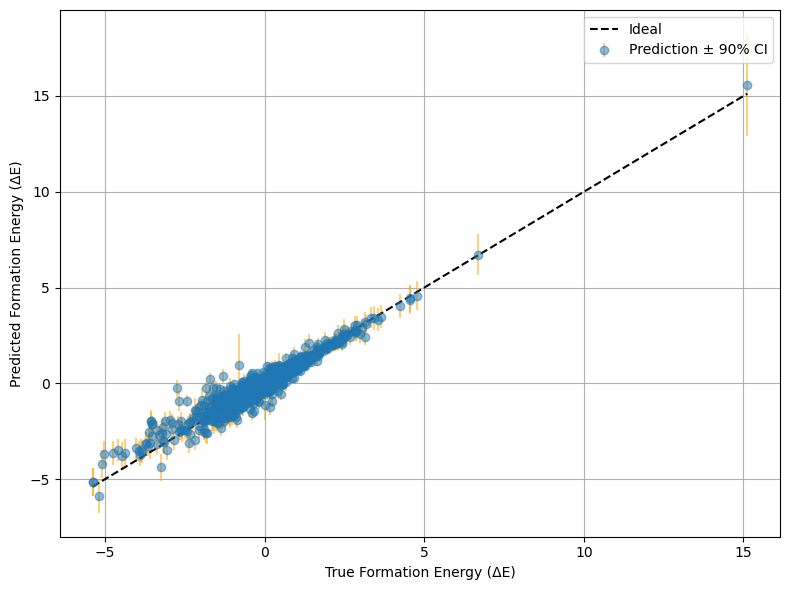

In [16]:
# 可视化：真实值vs预测值+区间
plt.figure(figsize=(8, 6))
plt.errorbar(y_true, mean_pred, yerr=z_score * std_pred, fmt='o', ecolor='orange', alpha=0.5, label='Prediction ± 90% CI')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Ideal')
# plt.title("90% Confidence Interval of Predictions vs Ground Truth")
plt.xlabel("True Formation Energy (ΔE)")
plt.ylabel("Predicted Formation Energy (ΔE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

模型结果保存

In [17]:
df_mlp = pd.DataFrame({
    'true': y_true,
    'pred': mean_pred,
    'std': std_pred
})

df_mlp['residual'] = df_mlp['true'] - df_mlp['pred']

df_mlp.to_csv('data/mlp_results.csv', index=False)